In [53]:
import torch
import torchio as tio

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import filters, segmentation, morphology, measure, transform

from skimage import feature
import cv2
import scipy.signal as signal

from ipywidgets import interact
import ipywidgets as widgets

C:\Users\maell\AppData\Local\Temp\ipykernel_60444\13255774.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.img.data)


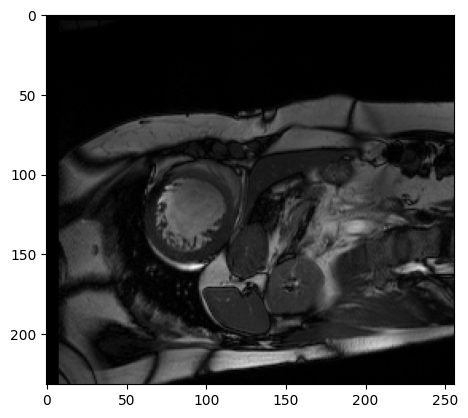

In [54]:
Tps = 0
Slice = 5

patient = tio.Subject(
    img=tio.ScalarImage('database/training/patient004/patient004_4d.nii.gz'),
)

t_img = torch.tensor(patient.img.data)
plt.imshow(t_img[Tps,:,:,Slice], cmap='gray')

In [55]:
def tf_mask(image4d, Tps=Tps, Slice=Slice):
    fft_img = torch.fft.fft(image4d, axis=0)
    filtred = fft_img
    filtred[:1, :, :, :] = 0.0
    filtred[3:, :, :, :] = 0.0

    timg2 = torch.abs(torch.fft.fft(filtred, axis=0))

    mask = np.array(timg2[Tps, :, :, Slice])
    mask = np.uint8(2*mask/np.max(mask)*255)
    kernel = np.ones((19, 19), np.uint8) 
    mask = cv2.dilate(mask, kernel, 1)
    mask = cv2.blur(mask,(21, 21))
    # print(np.max(mask))

    img_m = np.array(image4d[Tps, :, :, Slice], dtype=np.float64)
    img_m = np.uint8(img_m/np.max(img_m)*np.float64(mask))
    img_m = cv2.medianBlur(img_m,5)
    return img_m

In [56]:
img_m = tf_mask(t_img)
circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)

In [57]:
def to_rgb(gray):
    return cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)

In [58]:
def draw_cercles(image4d, circles=None, Tps=Tps, Slice=Slice):
  cimg = np.array(image4d[Tps, :, :, Slice])
  cimg = np.uint8(cimg/np.max(cimg)*255)
  cimg = to_rgb(cimg)
  if circles is not None:
    # print("circles !")
    circles = np.uint16(np.around(circles))
    for i in circles[0,:]:
      cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),1)
      cv2.circle(cimg,(i[0],i[1]),1,(255,0,0),2)
  # else:
    # print("no circles !")
  return cimg

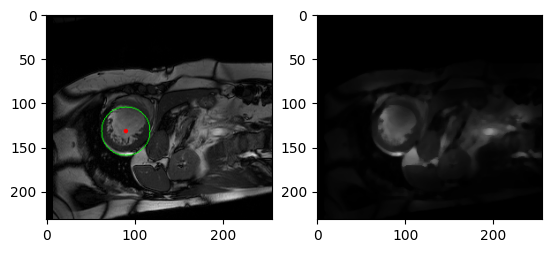

In [59]:
c_img = draw_cercles(t_img, circles)

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(c_img, vmin = 0, vmax=255)
ax2.imshow(img_m, cmap="grey", vmin = 0, vmax=255)

plt.show()

In [60]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles = cv2.HoughCircles(img_m, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=80,param2=40,minRadius=1,maxRadius=0)
        if circles is not None:
            reussite += 1
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [61]:
recherche_cercles(21)

C:\Users\maell\AppData\Local\Temp\ipykernel_60444\3350152194.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


Reussite : 15/21


In [62]:
## On remarque que parfois , les parametres de Hough sont trop restructifs et parfois c'est l'inverse.
# On va donc essayer de se rapprocher par dichotomie, des parametres qui nous renvoient un seul cercle par image.
# On fixe minRadius=1 et maxRadius=50.
# On va chercher param1 et param2 tels que le nombre de cercles soit égal à 1.

def best_hough(image, Tps=Tps, Slice=Slice):
    param2 = 40
    param1 = 2*param2
    circles = None
    stop = 0
    while circles is None or len(circles[0]) != 1 and stop < 100:
        circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, 20,
                            param1=param1,param2=param2,minRadius=1,maxRadius=50)
        if circles is None:
            param1 -= 1
            param2 -= 2
        elif len(circles[0]) > 1:
            param1 += 1
            param2 += 2
        stop += 1
    return circles, param1, param2

In [63]:
def recherche_cercles(nb):
    reussite = 0
    for i in range (1,nb+1):
        patient = tio.Subject(
            t1=tio.ScalarImage(f'database/training/patient{i:03d}/patient{i:03d}_4d.nii.gz'),
        )
        t_img = torch.tensor(patient.t1.data)
        img_m = tf_mask(t_img)
        circles, param1, param2 = best_hough(img_m)
        if len(circles[0]) == 1:
            reussite += 1
            print(f"circles pour {i} ! param1={param1} et param2={param2}")
        elif circles is None:
            print(f"Impossible de trouver un cercle pour l'image {i}")
        c_img = draw_cercles(t_img, circles)
        cv2.imwrite(f'test/cercles_{i:03d}.png', c_img)
    print(f"Reussite : {reussite}/{nb}")

In [64]:
recherche_cercles(100)

C:\Users\maell\AppData\Local\Temp\ipykernel_60444\3802031449.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_img = torch.tensor(patient.t1.data)


circles pour 1 ! param1=80 et param2=40
circles pour 2 ! param1=80 et param2=40
circles pour 3 ! param1=75 et param2=30
circles pour 4 ! param1=80 et param2=40
circles pour 5 ! param1=78 et param2=36
circles pour 6 ! param1=69 et param2=18
circles pour 7 ! param1=80 et param2=40
circles pour 8 ! param1=74 et param2=28
circles pour 9 ! param1=79 et param2=38
circles pour 10 ! param1=78 et param2=36
circles pour 11 ! param1=80 et param2=40
circles pour 12 ! param1=80 et param2=40
circles pour 13 ! param1=77 et param2=34
circles pour 14 ! param1=79 et param2=38
circles pour 15 ! param1=80 et param2=40
circles pour 16 ! param1=80 et param2=40
circles pour 17 ! param1=80 et param2=40
circles pour 18 ! param1=80 et param2=40
circles pour 19 ! param1=80 et param2=40
circles pour 20 ! param1=79 et param2=38
circles pour 21 ! param1=64 et param2=8
circles pour 23 ! param1=79 et param2=38
circles pour 24 ! param1=75 et param2=30
circles pour 25 ! param1=80 et param2=40
circles pour 26 ! param1=8